# Migrating point load with Te Change and Stratigraphy

$$y=x^2$$

In [2]:
from __future__ import print_function

import numpy as np
import pprint as pp
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt

import time
#import pylab as plt
from IPython import display

import imageio

%load_ext autoreload
%autoreload 1
%aimport flexureCodeForTeChange
%aimport makeAnimGif

In [3]:
## Constants...

g = 9.8 #ms-2
nu = 0.25
E = 7e10

In [4]:
# OPTION 1: Use this option to set strength using elastic thicknesses

Te_1 = 15000
D_1 = Te_1**4 * E / (12 * (1-nu**2) ) 

Te_2 = 40000
D_2 = Te_2**4 * E / (12 * (1-nu**2) ) 

In [5]:
## OPTION 2a: Uniform strength

D_1 = 3.7e23 #flexural regidity (N meters), strong plate
D_2 = D_1 #flexural regidity (N meters), weak plate

Te_1 = np.round( np.cbrt(12*(1-nu**2)*D_1/E), 0)
Te_2 = np.round( np.cbrt(12*(1-nu**2)*D_2/E), 0)

In [6]:
## OPTION 2: Use this to set strength using D

D_1 = 4.6e22 #flexural regidity (N meters), weak plate
D_2 = 3.7e23 #flexural regidity (N meters), strong plate

Te_1 = np.round( np.cbrt(12*(1-nu**2)*D_1/E), 0)
Te_2 = np.round( np.cbrt(12*(1-nu**2)*D_2/E), 0)

In [7]:
#density of sediment
rho_s = 3000 #kg/m3
rho_w = 1000 #kg/m3
rho_m = 3300 #kg/m3

rho_i = rho_s

h_s = 2000 #meters, load thickness
a_1 = (4*D_1/( g * (rho_m - rho_i)))**0.25 #flexural parameter alpha
a_2 = (4*D_2/( g * (rho_m - rho_i)))**0.25

n_halfWidth = 10000000

V_0 = 2e13

# Scale the load to height
orogenWidth = 100   # [km]
loadPerKm = V_0 / orogenWidth
orogenHeight = loadPerKm / (g * rho_s)
print("For a "+ str(orogenWidth) +" km wide orogen, the height is "+str(np.round(orogenHeight))+' km')

# Specify as a point load
contact_load = np.array( [V_0] )

# Since the model uses Te change as x=0, 
# we need to specify the loaction of the load in time to model convergence
loadLocations = np.arange( int(0.3*n_halfWidth), int(1.7*n_halfWidth), 1000)


For a 100 km wide orogen, the height is 6802721.0 km


In [8]:
len(loadLocations)

14000

In [9]:
# Calculate the initial and final profiles to specify initial and endmember models
t=1000
load_points = loadLocations[t]
n_load = np.array( [load_points] )

a_min = min( a_1,a_2 )
a_max = max( a_1,a_2 )
D_min = min( D_1, D_2)
x, w, load = flexureCodeForTeChange.Plate_Flexure_MN(a_min, a_min, D_min, D_min, contact_load, n_load, n_halfWidth)

z_min = np.min(w)
z_min = np.round(z_min, -2)-100

z_max = np.max(w)
z_max = np.round(z_max, -2)+300

x_min = -100
x_max = np.round(4*a_max/1000., -2)

print(x_max)
print(z_min)

600.0
-38300.0


In [10]:
print(Te_1, Te_2)

19481.0 39032.0


In [11]:
outputFilename = "PointLoad_WithStrat-"+"Te1_"+str(int(Te_1/1000))+"-Te2_"+str(int(Te_2/1000))+"-rhoInfill_"+str(rho_i)+"-V0_"+str(V_0).replace('.','p')

In [12]:
matplotlib.interactive(False)


In [13]:
#%matplotlib inline

In [43]:
z_FB = np.zeros_like( loadLocations )
z_DF = np.zeros_like( loadLocations )
z_deepest = np.zeros_like( loadLocations )

x_FB = np.zeros_like( loadLocations )
x_DF = np.zeros_like( loadLocations )
x_BM = np.zeros_like( loadLocations )
x_deepest = np.zeros_like( loadLocations )

basinWidth_DF2FB = np.zeros_like( loadLocations )
basinWidth_DF2BM = np.zeros_like( loadLocations )
basinWidth_DF2Deepest = np.zeros_like( loadLocations )

t_list = np.array([0])

plotFigs = True
addWChange = True

plotStratigraphy = True
stratTimestep = 100.
stratLayerNumber = 0

absolutePositionOfBasinMargin = np.array([])
flexuralProfileHistory = np.array([])
w_change_list = np.array([])

plotChronostrat = True

if(plotFigs == True):
    filename_list=[]
    
if(plotChronostrat==True):
    plotFigs = False
    plotStratigraphy = False
    savewChange = True

print("Getting uniform initial and final states")
V_0 = contact_load[0]

t = -1
load_points = loadLocations[t]

n_load = np.array( [load_points] )
x, w, load = flexureCodeForTeChange.Plate_Flexure_MN(a_1, a_1, D_1, D_1, contact_load, n_load, n_halfWidth)
initial_w = w
initial_x = x - x[load_points]

x, w, load = flexureCodeForTeChange.Plate_Flexure_MN(a_2, a_2, D_2, D_2, contact_load, n_load, n_halfWidth)
final_w = w
final_x = x - x[load_points]

# Specify an initial slab geometry
w_recent = np.copy( initial_w )

############
############
## Forward model time loop
print("Running temporal model")

#for t in range(0,len(loadLocations),20):
for t in range(0 ,len(loadLocations), int(stratTimestep)):

    print("OuterLoop t = ",t, end="\r")
    if(t>1):
        t_list = np.append(t_list, t)
    
    # Update point load parameters
    load_points = loadLocations[t]
    n_load = np.array( [load_points] )
    V_0 = contact_load[0]
    
    # Calculate flexural profile
    x, w, load = flexureCodeForTeChange.Plate_Flexure_MN(a_1, a_2, D_1, D_2, contact_load, n_load, n_halfWidth)
    
    # Elastic thickness change coincides with x=0 of flexure calculation
    Te = np.copy(x)
    n_Low = Te[Te<0]
    n_High = Te[Te>=0]

    # Determine location of Forebulge, Basin Margin and the Deepest point in the basin
    n_FB = n_load + np.argmax( w[ load_points : ] )
    n_BM = n_load + np.argmin( w[ load_points : n_FB[0]]*w[ load_points :n_FB[0] ] )
    n_deepest = int( np.argmin(w) )
    
    x_BM[t] = x[n_BM] - x[load_points]
    x_FB[t] = x[n_FB] - x[load_points]
    x_deepest[t] = x[n_deepest] - x[load_points]

    x_DF[t] = x[load_points]     # Deformation front coincident with point load
    
    z_FB[t] = w[ n_FB ]
    z_DF[t] = w[load_points]
    z_deepest[t] = w[n_deepest]
    
    # Calculate various horizonal distances from point load
    basinWidth_DF2FB[t] = x[n_FB] - x[load_points]
    basinWidth_DF2BM[t] = x[n_BM] - x[load_points]
    basinWidth_DF2Deepest[t] = x[n_deepest] - x[load_points]
    
    # Boolead to assess whether to spawn a new stratigraphic horizon
    analyseStratThisTimestep = (t/stratTimestep == t//stratTimestep )
    print(analyseStratThisTimestep)
    # Calculate uplift/subsidence of basin
    w_change = w - w_recent
    w_recent = np.copy(w)
    
    if(savewChange):
        if(len(w_change_list)==0):
            w_change_list = w_change.T
        else:
            w_change_list = np.vstack( (w_change_list, w_change.T) )
    
    # Are we plotting stratigraphy?
    if(plotStratigraphy == True):
        # Do we need to spawn a new horizon?
        if ( analyseStratThisTimestep ):
            absolutePositionOfBasinMargin = np.concatenate( (absolutePositionOfBasinMargin, n_BM) )
            if(len(flexuralProfileHistory)==0):
                flexuralProfileHistory = w.T
            else:
                flexuralProfileHistory = np.vstack( (flexuralProfileHistory, w.T) )
        
        print("flex profile shape 1",flexuralProfileHistory.shape)
        
        ## Extract subsidence profile
        n_subsidenceExtract = n_load + 500000
        subsidence_profile = []
        subsidence_layer = []
        n_subsidenceExtract_2 = n_load + 1000000
        subsidence_profile_2 = []
        subsidence_layer_2 = []

        # Delete stratigraphy if entirely underthrust to save memory
        if(len(absolutePositionOfBasinMargin)>3):
            print(absolutePositionOfBasinMargin)
            print( load_points )
            stratToKeep = absolutePositionOfBasinMargin > load_points
            print("keeping layers, number = ",stratToKeep.sum())
            absolutePositionOfBasinMargin = absolutePositionOfBasinMargin[stratToKeep]
            flexuralProfileHistory = flexuralProfileHistory[stratToKeep]
                         
        # Extract depth time profiles
        for n in range(0,len(absolutePositionOfBasinMargin)):
                tmp = flexuralProfileHistory[n]
                stratigraphicLayer = w - tmp
                subsidence_profile.append(stratigraphicLayer[n_subsidenceExtract])
                subsidence_layer.append(n)
                subsidence_profile_2.append(stratigraphicLayer[n_subsidenceExtract_2])
                subsidence_layer_2.append(n)

    # Are we plotting figures for the animation?
    if(plotFigs == True):
        # Create new filename and add to list
        filename = "tmpFigs/tmp_strat_"+str(t)+".png"
        filename_list.append(filename)
        
        #### Create new figure
        plt.figure(figsize=(16,12))
        
        plt.subplot(1,2,1)
        ## Add stratigraphy
        if( (plotStratigraphy == True) * (t>0)):
            
            for n in range(0,len(flexuralProfileHistory)):
                #stratigraphicLayer = w - np.sum( accommodationGeneration[0:n-1], axis=0)
                tmp = flexuralProfileHistory[n]
                stratigraphicLayer = w - tmp
                nStrat = (stratigraphicLayer > w) 
                nStrat[ int(n_FB) : ] = False
                nStrat[  : load_points ] = False
                #if( (t-totalConvergenceWhenDeposited[n]) < (n_BM - n_load)):
                #plt.plot(( x[load_points:int(n_BM)] - x[load_points] )/1000, stratigraphicLayer[load_points:int(n_BM)] , label=str(n), linestyle="-." )
                if( np.sum(nStrat)>1 ):
                    plt.plot(( x[nStrat] - x[load_points] )/1000, stratigraphicLayer[nStrat] , label=str(n), linestyle="-." )
                
        ## Add strong and weak endmember solutions as dashed lines
        plt.plot(initial_x/1000, initial_w, linestyle=":", linewidth=0.5, label="Initial profile" )
        plt.plot(final_x/1000, final_w, linestyle=":", linewidth=0.5, label="Final profile" )

                
        ## Add w change  (MAKE NEW FIGURE??)
        if(addWChange):
            n_positive = w_change>0
            plt.plot( (x[n_positive]-x[load_points])/1000, 4*w_change[n_positive], c='r',linestyle=":")
            n_negative = w_change<0
            plt.plot( (x[n_negative]-x[load_points])/1000, 4*w_change[n_negative], c='b',linestyle=":")

        
        plt.plot((x[n_Low]-x[load_points])/1000, w[n_Low], label="Weak plate $T_e$ = "+str(Te_2), c="r" )
        plt.plot((x[n_High]-x[load_points])/1000, w[n_High], label="Strong plate $T_e$ = "+str(Te_1), c='g' )

        plt.plot(x_FB[t_list]/1000, z_FB[t_list], label="Translation of forebulge", linestyle="--")
        plt.plot(x_BM[t_list]/1000, np.zeros_like(x_BM[t_list]), label="Translation of basin margin", linestyle="--")
        plt.plot(x_deepest[t_list]/1000, z_deepest[t_list], label="Translation of deepest point", linestyle="--")

        plt.axvline(x=0,linestyle=':')
        plt.axhline(y=0,linestyle=':')
        
        plt.axvline(x=(x[n_subsidenceExtract]-x[load_points])/1000, c='b')
        plt.axvline(x=(x[n_subsidenceExtract_2]-x[load_points])/1000, c='b')
        plt.ylabel("Slab evevation [m]")
        plt.xlabel("Location relative to deformation front [km]")
        plt.xlim(x_min-1000, x_max)
        plt.ylim(z_min, 300)
        TeRatio = np.round(Te_2/Te_1,2)
        plt.title( "Point Load at $x=0$    Time = "+str(t)+"   Te Ratio = "+ str(TeRatio) )
        plt.legend(loc='lower right')
        
        plt.subplot(1,2,2)
        subsidence_profile = np.array( subsidence_profile ).flatten()        
        subsidence_profile_2 = np.array( subsidence_profile_2 ).flatten()

        subsidence_layer = np.array( subsidence_layer ).flatten()    
        subsidence_layer_2 = np.array( subsidence_layer_2 ).flatten()  
        
        n = subsidence_profile>=w[n_subsidenceExtract]
        plt.plot(subsidence_layer[n], w[n_subsidenceExtract]-subsidence_profile[n], label="Depth-time")
        
        n = subsidence_profile_2>=w[n_subsidenceExtract_2]
        plt.plot(subsidence_layer_2[n], w[n_subsidenceExtract_2]-subsidence_profile_2[n], label="Depth-time 2")
        plt.ylim(z_min, 300)
        plt.axhline(y=w[n_subsidenceExtract], label="slab")
        plt.axhline(y=w[n_subsidenceExtract_2], label="slab 2")
        plt.axhline(y=0, label="Surface")
        plt.ylabel("Subsidence")
        plt.xlabel("Strat Layer number (uniformly generated)")
        plt.legend()
        
        plt.savefig(filename)
        plt.close('all')
        

print("Finished Modelling")

if(plotChronostrat == True):
    t = np.arange(0, len(x_BM))    
    plt.plot(x_BM, t, label="Basin Margin")
    plt.plot(x_FB, t, label="forebulge")
    plt.plot(x_deepest, t, label="deepest")
    plt.plot(np.zeros_like(t), t, label = "DF (i.e. load location)")
    plt.legend()
    plt.savefig("chronostrateTest.png")

if(plotFigs == True):
    print("Making animated GIF")
    pwd = "/Users/mnaylor/OneDrive - University of Edinburgh/MyProjects/agata"
    movieFilename = "Movie_"+outputFilename+".gif"
    makeAnimGif.makeAnim(filename_list, pwd, outputFile=movieFilename)

Getting uniform initial and final states
Running temporal model
TruerLoop t =  0
TruerLoop t =  100
TruerLoop t =  200
TruerLoop t =  300
TruerLoop t =  400
TruerLoop t =  500
TruerLoop t =  600
TruerLoop t =  700
TruerLoop t =  800
TruerLoop t =  900
TruerLoop t =  1000
TruerLoop t =  1100
TruerLoop t =  1200
TruerLoop t =  1300
TruerLoop t =  1400
TruerLoop t =  1500
TruerLoop t =  1600
TruerLoop t =  1700
TruerLoop t =  1800
TruerLoop t =  1900
TruerLoop t =  2000
TruerLoop t =  2100
TruerLoop t =  2200
TruerLoop t =  2300
TruerLoop t =  2400
TruerLoop t =  2500
TruerLoop t =  2600
TruerLoop t =  2700
TruerLoop t =  2800
TruerLoop t =  2900
TruerLoop t =  3000
TruerLoop t =  3100
TruerLoop t =  3200
TruerLoop t =  3300
TruerLoop t =  3400
TruerLoop t =  3500
TruerLoop t =  3600
TruerLoop t =  3700


KeyboardInterrupt: 

In [36]:
%matplotlib inline

In [47]:
len(w_change_list)

37

In [ ]:
for i in range(3):
    plt.plot( (w_change_list[i,:]/1000+10.*i) )

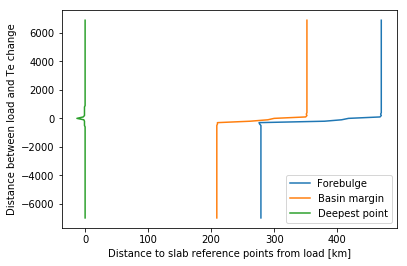

In [34]:
outputTimes = np.arange(0 ,len(loadLocations), int(stratTimestep))

plt.plot(x_FB[outputTimes]/1000, x_DF[outputTimes]/1000, label="Forebulge")
plt.plot(x_BM[outputTimes]/1000,  x_DF[outputTimes]/1000, label="Basin margin")
plt.plot(x_deepest[outputTimes]/1000,  x_DF[outputTimes]/1000, label="Deepest point")
plt.ylabel("Distance between load and Te change")
plt.xlabel("Distance to slab reference points from load [km]")
plt.legend()

In [11]:


filename_list=[]
for t in range(100,13600,100):
    filename = "tmpFigs/tmp_strat_"+str(t)+".png"
    filename_list.append(filename)
        
plotFigs = True

if(plotFigs == True):
    print("Making animated GIF")
    pwd = "/Users/mnaylor/OneDrive - University of Edinburgh/MyProjects/agata"
    movieFilename = "Movie_"+outputFilename+".gif"
    makeAnimGif.makeAnim(filename_list, pwd, outputFile=movieFilename)

14000

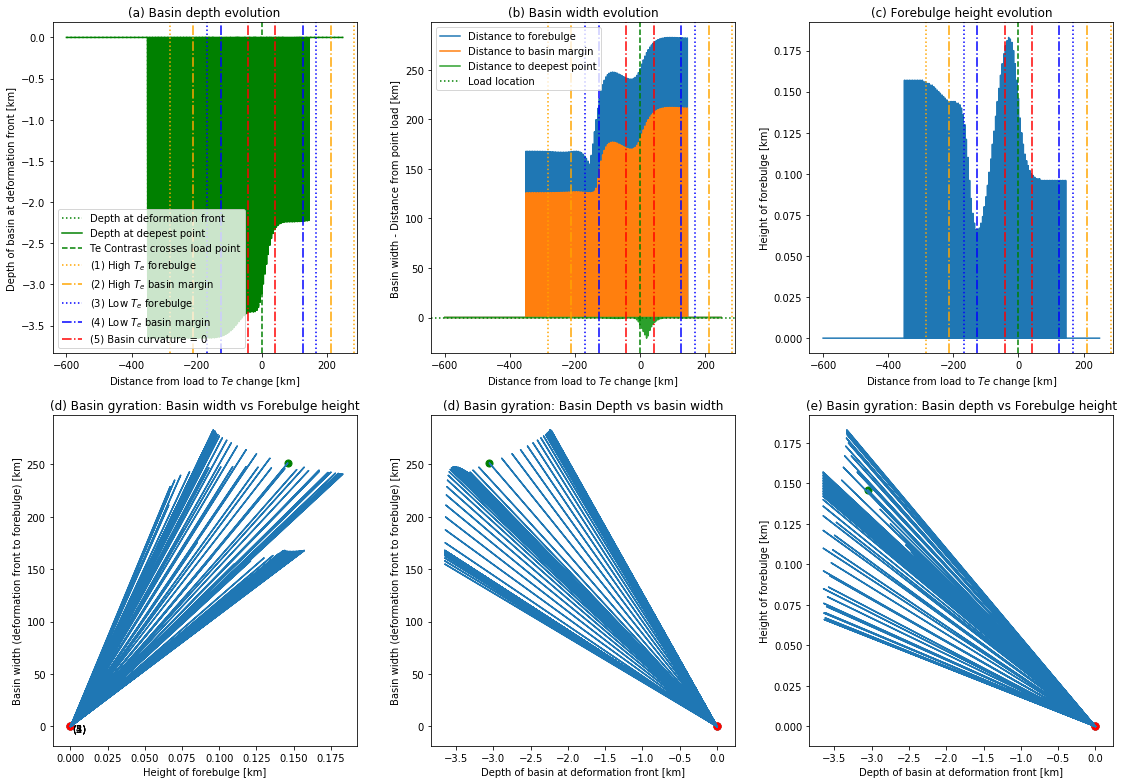

In [113]:
### PAPER FIGURE

plt.figure(figsize=(16,11))

a_high = np.max( [a_1,a_2] )
a_low = np.min( [a_1,a_2] )

n_TeCrossingDF = (loadLocations-n_halfWidth)==0
x_forebulge_low = np.pi*a_low
x_forebulge_high = np.pi*a_high
x_BM_low = 3*np.pi/4*a_low
x_BM_high = 3*np.pi/4*a_high
x_StressChange_high = np.pi/4*a_high
x_StressChange_low = np.pi/4*a_low

n_forebulge_low = np.argmin( ((loadLocations-n_halfWidth)+x_forebulge_low)**2)
n_forebulge_high = np.argmin( ((loadLocations-n_halfWidth)+x_forebulge_high)**2)
n_BM_low = np.argmin( ((loadLocations-n_halfWidth)+x_BM_low)**2)
n_BM_high = np.argmin( ((loadLocations-n_halfWidth)+x_BM_high)**2)
n_StressChange_high = np.argmin( ((loadLocations-n_halfWidth)+x_StressChange_high)**2)
n_StressChange_low = np.argmin( ((loadLocations-n_halfWidth)+x_StressChange_low)**2)


plt.subplot(2,3,3)
plt.plot((loadLocations-n_halfWidth)/1000., z_FB/1000.)
plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Height of forebulge [km]")
plt.title("(c) Forebulge height evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.", label="(4) high $T_e$ basin margin")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.")

plt.subplot(2,3,1)
plt.plot((loadLocations-n_halfWidth)/1000., z_DF/1000., label="Depth at deformation front", c='g', linestyle=":")
plt.plot((loadLocations-n_halfWidth)/1000., z_deepest/1000., label="Depth at deepest point", c='g', linestyle="-")

plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Depth of basin at deformation front [km]")
plt.title("(a) Basin depth evolution")
plt.axvline(0, c='g', linestyle="--", label="Te Contrast crosses load point")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":", label="(1) High $T_e$ forebulge")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.", label="(2) High $T_e$ basin margin")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":", label="(3) Low $T_e$ forebulge")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.", label="(4) Low $T_e$ basin margin")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.", label="(5) Basin curvature = 0")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.")

plt.legend(loc="lower left")

plt.subplot(2,3,2)
plt.plot((loadLocations-n_halfWidth)/1000., basinWidth_DF2FB/1000., label="Distance to forebulge")
plt.plot((loadLocations-n_halfWidth)/1000., basinWidth_DF2BM/1000., label="Distance to basin margin")
plt.plot((loadLocations-n_halfWidth)/1000., basinWidth_DF2Deepest/1000., label="Distance to deepest point")
plt.axhline(y=0, label="Load location", linestyle=":",c='g')
plt.xlabel("Distance from load to $Te$ change [km]")
plt.ylabel("Basin width - Distance from point load [km]")
plt.title("(b) Basin width evolution")

plt.axvline(0, c='g', linestyle="--")
plt.axvline(x=-x_forebulge_high/1000., c='orange', linestyle=":")
plt.axvline(x=-x_BM_high/1000., c='orange', linestyle="-.")
plt.axvline(x=-x_forebulge_low/1000., c='b', linestyle=":")
plt.axvline(x=-x_BM_low/1000., c='b', linestyle="-.")
plt.axvline(x=-x_StressChange_low/1000., c='r', linestyle="-.")

plt.axvline(x=x_forebulge_high/1000., c='orange', linestyle=":")
plt.axvline(x=x_BM_high/1000., c='orange', linestyle="-.")
plt.axvline(x=x_forebulge_low/1000., c='b', linestyle=":")
plt.axvline(x=x_BM_low/1000., c='b', linestyle="-.")
plt.axvline(x=x_StressChange_low/1000., c='r', linestyle="-.")

plt.legend()



plt.subplot(2,3,4)
plt.plot( z_FB/1000., basinWidth_DF2FB/1000.)
plt.scatter( z_FB[n_TeCrossingDF]/1000., basinWidth_DF2FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Height of forebulge [km]")
plt.ylabel("Basin width (deformation front to forebulge) [km]")
plt.title("(d) Basin gyration: Basin width vs Forebulge height")

n = ["(1)", "(2)","(3)","(4)","(5)"]
xs = [z_FB[n_forebulge_high]/1000., z_FB[n_BM_high]/1000., z_FB[n_forebulge_low]/1000., z_FB[n_BM_low]/1000., z_FB[n_StressChange_low]/1000. ]
ys = [basinWidth_DF2FB[n_forebulge_high]/1000., basinWidth_DF2FB[n_BM_high]/1000.,basinWidth_DF2FB[n_forebulge_low]/1000., basinWidth_DF2FB[n_BM_low]/1000.,  basinWidth_DF2FB[n_StressChange_low]/1000.]

for i, txt in enumerate(n):
    plt.annotate(txt, (xs[i], ys[i]), xytext=(xs[i]+0.001,ys[i]-5))


plt.scatter(z_FB[n_forebulge_low]/1000., basinWidth_DF2FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_FB[n_forebulge_high]/1000., basinWidth_DF2FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_FB[n_BM_low]/1000., basinWidth_DF2FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_FB[n_BM_high]/1000., basinWidth_DF2FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_FB[n_StressChange_low]/1000., basinWidth_DF2FB[n_StressChange_low]/1000., c="r", s=50)


plt.subplot(2,3,5)
plt.plot( z_DF/1000., basinWidth_DF2FB/1000.)
plt.scatter( z_DF[n_TeCrossingDF]/1000., basinWidth_DF2FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Depth of basin at deformation front [km]")
plt.ylabel("Basin width (deformation front to forebulge) [km]")
plt.title("(d) Basin gyration: Basin Depth vs basin width")


plt.scatter(z_DF[n_forebulge_low]/1000., basinWidth_DF2FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_forebulge_high]/1000., basinWidth_DF2FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_DF[n_BM_low]/1000., basinWidth_DF2FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_BM_high]/1000., basinWidth_DF2FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_DF[n_StressChange_low]/1000., basinWidth_DF2FB[n_StressChange_low]/1000., c="r", s=50)



plt.subplot(2,3,6)
plt.plot( z_DF/1000., z_FB/1000.)
plt.scatter( z_DF[n_TeCrossingDF]/1000., z_FB[n_TeCrossingDF]/1000., c="g", s=50)
plt.xlabel("Depth of basin at deformation front [km]")
plt.ylabel("Height of forebulge [km]")
plt.title("(e) Basin gyration: Basin depth vs Forebulge height")


plt.scatter(z_DF[n_forebulge_low]/1000., z_FB[n_forebulge_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_forebulge_high]/1000., z_FB[n_forebulge_high]/1000., c="orange", s=50)
plt.scatter(z_DF[n_BM_low]/1000., z_FB[n_BM_low]/1000., c="b", s=50)
plt.scatter(z_DF[n_BM_high]/1000., z_FB[n_BM_high]/1000., c="orange", s=50)
#plt.scatter(z_FB[n_StressChange_high]/1000., basinWidth_DF2FB[n_StressChange_high]/1000., c="r", s=50)
plt.scatter(z_DF[n_StressChange_low]/1000., z_FB[n_StressChange_low]/1000., c="r", s=50)

plt.tight_layout()

metricFigureFilename = "BasinMetricFigure_"+outputFilename+".png"
plt.savefig(metricFigureFilename)
plt.show()

In [84]:
x = np.array([1,2,3])
y = np.array([2,2,2])

c = np.array([1,1,1])

c = np.vstack( ( c, x.T) )
c = np.vstack( ( c, y.T) )
c = np.vstack( ( c, y.T) )


print(len(c))
c = np.delete(c, (2), axis=0 )
print(c)

4
[[1 1 1]
 [1 2 3]
 [2 2 2]]


array([[1, 2, 3],
       [2, 2, 2]])